In [28]:
import torch 
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms 
from torchvision.datasets import Omniglot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px 
from tqdm import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, datasets

In [29]:
augmentation1 = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augmentation2 = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [30]:
class SimSiamOmniglot(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __getitem__(self, index):
        img, _ = self.base_dataset[index]
        view1 = augmentation1(img)
        view2 = augmentation2(img)
        return view1, view2

    def __len__(self):
        return len(self.base_dataset)

In [31]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim=64, out_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hidden_dim, kernel_size=3, padding=1),  # 28x28
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 14x14

            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 7x7

            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 3x3

            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # -> 1x1
        )
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.encoder(x)          # Shape: (B, hidden_dim, 1, 1)
        x = x.view(x.size(0), -1)    # Flatten to (B, hidden_dim)
        return self.fc(x)           

In [32]:
class MLP(nn.Module):
    def __init__(self, in_dim=64, proj_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, proj_dim)
        )

    def forward(self, x):
        return self.mlp(x)

In [33]:
def simsiam_loss(p, z):
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return - (p * z.detach()).sum(dim=1).mean()

In [34]:
def identity(x):
    return x

In [35]:
dataset_path = "./dataset"
dataset = datasets.ImageFolder(root=dataset_path, transform=identity)
simsiam_dataset = SimSiamOmniglot(dataset)
loader = DataLoader(simsiam_dataset, batch_size=264, shuffle=True,drop_last=True)

In [36]:
len(loader)

33

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [38]:
encoder = Encoder().to(device)
projector = MLP().to(device)
predictor = MLP().to(device)

In [39]:
optimizer = Adam(list(encoder.parameters()) + list(projector.parameters()) + list(predictor.parameters()), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [40]:
loss_history = []

for epoch in range(1, 101): 
    encoder.train()
    projector.train()
    predictor.train()
    total_loss = 0

    loop = tqdm(loader, desc=f"Epoch {epoch}", leave=False)
    for view1, view2 in loop:
        view1, view2 = view1.to(device), view2.to(device)

        h1 = encoder(view1)
        z1 = projector(h1)
        p1 = predictor(z1)

        h2 = encoder(view2)
        z2 = projector(h2)
        p2 = predictor(z2)

        loss = 0.5 * (simsiam_loss(p1, z2) + simsiam_loss(p2, z1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch} | Avg Loss: {avg_loss:.4f}")

    scheduler.step(avg_loss)


Epoch 1 | Avg Loss: -0.0466


Epoch 2 | Avg Loss: -0.1235


Epoch 3 | Avg Loss: -0.1938


Epoch 4 | Avg Loss: -0.2611


Epoch 5 | Avg Loss: -0.3323


Epoch 6 | Avg Loss: -0.4009


Epoch 7 | Avg Loss: -0.4673


Epoch 8 | Avg Loss: -0.5322


Epoch 9 | Avg Loss: -0.5928


Epoch 10 | Avg Loss: -0.6506


Epoch 11 | Avg Loss: -0.7049


Epoch 12 | Avg Loss: -0.7530


Epoch 13 | Avg Loss: -0.7940


Epoch 14 | Avg Loss: -0.8281


Epoch 15 | Avg Loss: -0.8554


Epoch 16 | Avg Loss: -0.8767


Epoch 17 | Avg Loss: -0.8939


Epoch 18 | Avg Loss: -0.9088


Epoch 19 | Avg Loss: -0.9212


Epoch 20 | Avg Loss: -0.9317


Epoch 21 | Avg Loss: -0.9412


Epoch 22 | Avg Loss: -0.9489


Epoch 23 | Avg Loss: -0.9553


Epoch 24 | Avg Loss: -0.9605


Epoch 25 | Avg Loss: -0.9648


Epoch 26 | Avg Loss: -0.9682


Epoch 27 | Avg Loss: -0.9712


Epoch 28 | Avg Loss: -0.9737


Epoch 29 | Avg Loss: -0.9764


Epoch 30 | Avg Loss: -0.9786


Epoch 31 | Avg Loss: -0.9805


Epoch 32 | Avg Loss: -0.9823


Epoch 33 | Avg Loss: -0.9840


Epoch 34 | Avg Loss: -0.9856


Epoch 35 | Avg Loss: -0.9869


Epoch 36 | Avg Loss: -0.9881


Epoch 37 | Avg Loss: -0.9890


Epoch 38 | Avg Loss: -0.9898


Epoch 39 | Avg Loss: -0.9905


Epoch 40 | Avg Loss: -0.9909


Epoch 41 | Avg Loss: -0.9915


Epoch 42 | Avg Loss: -0.9920


Epoch 43 | Avg Loss: -0.9923


Epoch 44 | Avg Loss: -0.9927


Epoch 45 | Avg Loss: -0.9930


Epoch 46 | Avg Loss: -0.9931


Epoch 47 | Avg Loss: -0.9934


Epoch 48 | Avg Loss: -0.9935


Epoch 49 | Avg Loss: -0.9937


Epoch 50 | Avg Loss: -0.9939


Epoch 51 | Avg Loss: -0.9940


Epoch 52 | Avg Loss: -0.9942


Epoch 53 | Avg Loss: -0.9943


Epoch 54 | Avg Loss: -0.9945


Epoch 55 | Avg Loss: -0.9946


Epoch 56 | Avg Loss: -0.9948


Epoch 57 | Avg Loss: -0.9949


Epoch 58 | Avg Loss: -0.9950


Epoch 59 | Avg Loss: -0.9952


Epoch 60 | Avg Loss: -0.9955


Epoch 61 | Avg Loss: -0.9956


Epoch 62 | Avg Loss: -0.9957


Epoch 63 | Avg Loss: -0.9958


Epoch 64 | Avg Loss: -0.9959


Epoch 65 | Avg Loss: -0.9960


Epoch 66 | Avg Loss: -0.9960


Epoch 67 | Avg Loss: -0.9962


Epoch 68 | Avg Loss: -0.9964


Epoch 69 | Avg Loss: -0.9964


Epoch 70 | Avg Loss: -0.9964


Epoch 71 | Avg Loss: -0.9965


Epoch 72 | Avg Loss: -0.9965


Epoch 73 | Avg Loss: -0.9966


Epoch 74 | Avg Loss: -0.9966


Epoch 75 | Avg Loss: -0.9967


Epoch 76 | Avg Loss: -0.9966


Epoch 77 | Avg Loss: -0.9967


Epoch 78 | Avg Loss: -0.9967


Epoch 79 | Avg Loss: -0.9967


Epoch 80 | Avg Loss: -0.9967


Epoch 81 | Avg Loss: -0.9968


Epoch 82 | Avg Loss: -0.9968


Epoch 83 | Avg Loss: -0.9969


Epoch 84 | Avg Loss: -0.9968


Epoch 85 | Avg Loss: -0.9970


Epoch 86 | Avg Loss: -0.9970


Epoch 87 | Avg Loss: -0.9970


Epoch 88 | Avg Loss: -0.9970


Epoch 89 | Avg Loss: -0.9970


Epoch 90 | Avg Loss: -0.9971


Epoch 91 | Avg Loss: -0.9971


Epoch 92 | Avg Loss: -0.9972


Epoch 93 | Avg Loss: -0.9971


Epoch 94 | Avg Loss: -0.9973


Epoch 95 | Avg Loss: -0.9973


Epoch 96 | Avg Loss: -0.9974


Epoch 97 | Avg Loss: -0.9974


Epoch 98 | Avg Loss: -0.9974


Epoch 99 | Avg Loss: -0.9976


Epoch 100 | Avg Loss: -0.9975


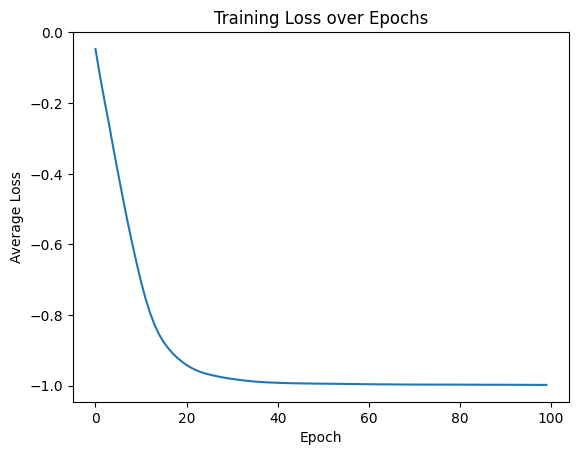

In [41]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [42]:
torch.save(encoder.state_dict(), 'simsiam_encoder.pth')
print("Encoder saved to simsiam_encoder.pth")

Encoder saved to simsiam_encoder.pth
